
# Module 2 — Logistic Regression & Neural Network (Fashion‑MNIST)

This notebook follows the **Module 2** assignment flow:
- Load **Fashion‑MNIST** (train/test)
- Normalize and reshape data
- **Binary logistic regression** from scratch (NumPy) on a chosen pair of classes
- Train and plot **loss/accuracy**
- **Multiclass neural network** (Keras) baseline for all 10 classes with accuracy/loss curves

> Fill your name & ID below if required by your course.


In [1]:

NAME = "David Dinh"
STUDENT_ID = "dd26"


## 0) Imports & setup

In [2]:

%pip install tensorflow

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(144)


Note: you may need to restart the kernel to use updated packages.


## 1) Load & prepare Fashion‑MNIST

In [3]:

# Loads (x_train, y_train), (x_test, y_test) with shapes ((60000, 28, 28), (10000, 28, 28))
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1]
x_train = (x_train / 255.0).astype("float32")
x_test  = (x_test  / 255.0).astype("float32")

print("Train:", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,)
Test:  (10000, 28, 28) (10000,)



## 2) Binary Logistic Regression (from scratch)

We'll classify between **two classes** (set them below).  
Default is `T-shirt/top (0)` vs `Trouser (1)` which is linearly separable enough for a nice demo.


In [4]:

# Choose any pair in {0..9}. Example: (0,1) = T-shirt/top vs Trouser
CLASSES = (0, 1)

# Filter dataset to the two classes
def filter_two_classes(x, y, classes):
    idx = np.isin(y, classes)
    x, y = x[idx], y[idx]
    # map labels to {0,1}
    y_bin = (y == classes[1]).astype("float32").reshape(-1, 1)
    return x, y_bin

x_train_bin, y_train_bin = filter_two_classes(x_train, y_train, CLASSES)
x_test_bin,  y_test_bin  = filter_two_classes(x_test,  y_test,  CLASSES)

# Flatten images to vectors
x_train_bin = x_train_bin.reshape(len(x_train_bin), -1)
x_test_bin  = x_test_bin.reshape(len(x_test_bin), -1)

print("Binary shapes:", x_train_bin.shape, y_train_bin.shape, x_test_bin.shape, y_test_bin.shape)


Binary shapes: (12000, 784) (12000, 1) (2000, 784) (2000, 1)


### 2.1 Sigmoid, loss, gradients, training loop

Epoch 10/50 | loss 0.1998/0.2043 | acc 0.960/0.950
Epoch 20/50 | loss 0.1535/0.1582 | acc 0.963/0.955
Epoch 30/50 | loss 0.1329/0.1376 | acc 0.965/0.959
Epoch 40/50 | loss 0.1200/0.1247 | acc 0.968/0.962
Epoch 50/50 | loss 0.1107/0.1154 | acc 0.970/0.964


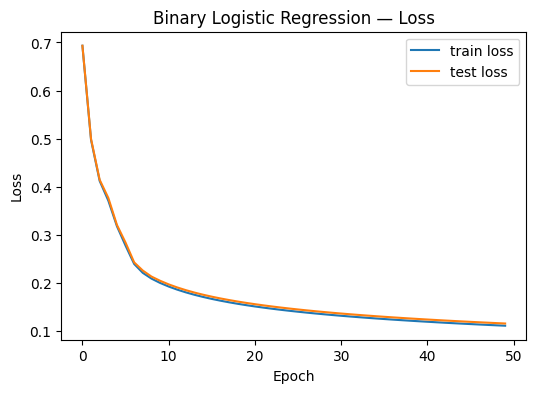

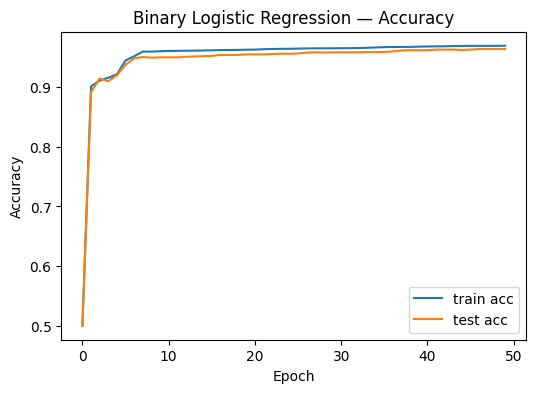

In [5]:

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_loss(y_hat, y):
    # Binary cross-entropy averaged over N
    eps = 1e-8
    y_hat = np.clip(y_hat, eps, 1.0-eps)
    return float(np.mean(-(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))))

def bce_gradients(X, y, w, b):
    # Gradients for logistic regression (X: NxD, y: Nx1)
    N = X.shape[0]
    z = X.dot(w) + b
    y_hat = sigmoid(z)
    dz = (y_hat - y) / N
    dw = X.T.dot(dz)
    db = np.sum(dz)
    return dw, db

def train_logreg(X_train, y_train, X_test, y_test, lr=0.1, epochs=50):
    D = X_train.shape[1]
    w = np.zeros((D,1), dtype="float32")
    b = 0.0
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    for ep in range(epochs):
        # forward
        y_hat_train = sigmoid(X_train.dot(w) + b)
        y_hat_test  = sigmoid(X_test.dot(w) + b)
        # metrics
        train_losses.append(bce_loss(y_hat_train, y_train))
        test_losses.append(bce_loss(y_hat_test,  y_test))
        train_accs.append(float(np.mean((y_hat_train >= 0.5) == y_train)))
        test_accs.append(float(np.mean((y_hat_test  >= 0.5) == y_test)))
        # grads
        dw, db = bce_gradients(X_train, y_train, w, b)
        # update
        w -= lr * dw
        b -= lr * db
        if (ep+1) % max(1, epochs//5) == 0:
            print(f"Epoch {ep+1}/{epochs} | loss {train_losses[-1]:.4f}/{test_losses[-1]:.4f} "
                  f"| acc {train_accs[-1]:.3f}/{test_accs[-1]:.3f}")
    return (w, b), np.array(train_losses), np.array(test_losses), np.array(train_accs), np.array(test_accs)

(w, b), trL, teL, trA, teA = train_logreg(x_train_bin, y_train_bin, x_test_bin, y_test_bin, lr=0.1, epochs=50)

# Plots
plt.figure(figsize=(6,4))
plt.plot(trL, label="train loss")
plt.plot(teL, label="test loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Binary Logistic Regression — Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(trA, label="train acc")
plt.plot(teA, label="test acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Binary Logistic Regression — Accuracy"); plt.legend(); plt.show()



## 3) Multiclass Neural Network (Keras)

A compact baseline for **all 10 classes**:
- `Flatten → Dense(128, relu) → Dense(10, softmax)`
- Trained with Adam and `sparse_categorical_crossentropy`
- ≤10 epochs by default


Epoch 1/10
422/422 - 2s - 4ms/step - accuracy: 0.8040 - loss: 0.5711 - val_accuracy: 0.8487 - val_loss: 0.4284
Epoch 2/10
422/422 - 1s - 2ms/step - accuracy: 0.8567 - loss: 0.4062 - val_accuracy: 0.8605 - val_loss: 0.3811
Epoch 3/10
422/422 - 1s - 2ms/step - accuracy: 0.8706 - loss: 0.3641 - val_accuracy: 0.8717 - val_loss: 0.3540
Epoch 4/10
422/422 - 1s - 2ms/step - accuracy: 0.8804 - loss: 0.3367 - val_accuracy: 0.8772 - val_loss: 0.3502
Epoch 5/10
422/422 - 1s - 2ms/step - accuracy: 0.8853 - loss: 0.3201 - val_accuracy: 0.8777 - val_loss: 0.3407
Epoch 6/10
422/422 - 1s - 2ms/step - accuracy: 0.8903 - loss: 0.3055 - val_accuracy: 0.8762 - val_loss: 0.3455
Epoch 7/10
422/422 - 1s - 2ms/step - accuracy: 0.8951 - loss: 0.2907 - val_accuracy: 0.8812 - val_loss: 0.3239
Epoch 8/10
422/422 - 1s - 2ms/step - accuracy: 0.8977 - loss: 0.2800 - val_accuracy: 0.8677 - val_loss: 0.3520
Epoch 9/10
422/422 - 1s - 2ms/step - accuracy: 0.9020 - loss: 0.2704 - val_accuracy: 0.8840 - val_loss: 0.3248
E

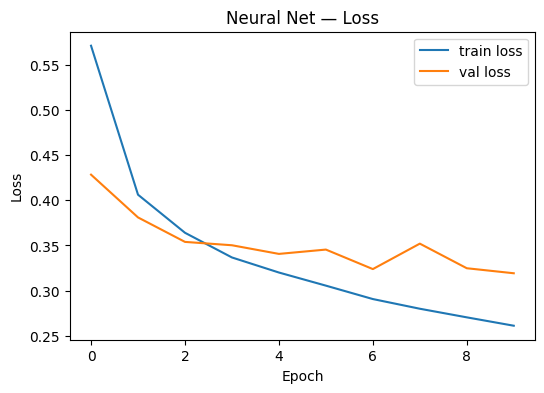

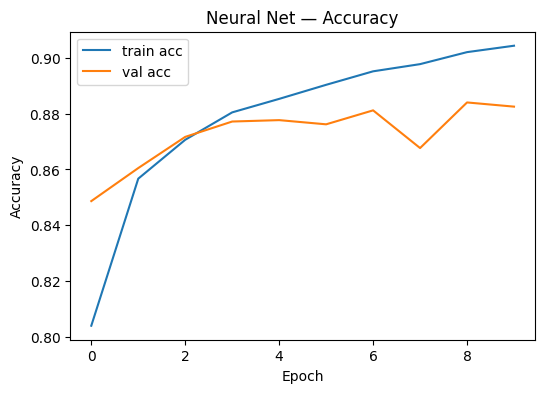

In [6]:

# Re-load raw (to keep the code isolated) and normalize
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = (x_train / 255.0).astype("float32")
x_test  = (x_test  / 255.0).astype("float32")

model = keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", round(float(test_acc), 4))

# Plot training curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Neural Net — Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Neural Net — Accuracy"); plt.legend(); plt.show()
